In [1]:
%matplotlib inline
import numpy as np

from fatiando import mesher, gridder, utils, gravmag
from fatiando.gravmag import prism, sphere, fourier
from fatiando.utils import ang2vec, nt2si
from fatiando.vis import mpl

from fatiando.gravmag.eqlayer import EQLTotalField
from fatiando.inversion.regularization import Damping, LCurve

In [2]:
def ASA3D(Dxtf, Dytf, Dztf):
    '''
    Amplitude do Sinal Analítico 3D
    
    sistema de coordenadas
      x: dimensão infinita
      y: direção ao longo do perfil
      z: aponta para baixo
    
    input
      Dxtf: array com a derivada espacial da ACT na direção x
      Dytf: array com a derivada espacial da ACT na direção y
      Dztf: array com a derivada espacial da ACT na direção z
      
    output
      asa3D: array com a amplitude do sinal analítico 3D

    '''

    asa3D = np.sqrt(Dxtf**2 + Dytf**2 + Dztf**2)

    return asa3D

In [3]:
''' Coordenadas das observações '''
area = (-5000, 5000, -5000, 5000)
shape = (100, 100)
z0 = -300
x, y, z = gridder.regular(area, shape, z=z0)

In [4]:
''' Corpo sintético '''

inc, dec = -30.0, -14.5 # inclinação e declinação do campo geomagnético
incs, decs = 1.0, -120.0 # inclinação e declinação da magnetização do corpo
corpo = [mesher.Prism(-2000, 2000, -2000, 2000, 0, 2000, {'magnetization': ang2vec(1.0, incs, decs)})]

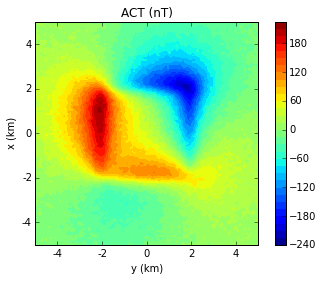

In [5]:
''' Cálculo da Anomalia de Campo Total (ACT) '''
tf = prism.tf(x, y, z, corpo, inc, dec)
tf = utils.contaminate(tf, 5.0)

mpl.close('all')
mpl.figure()
#mpl.subplot(2, 1, 1)
mpl.title("ACT (nT)")
mpl.axis('scaled')
mpl.contourf(y, x, tf, shape, 30)
mpl.colorbar()
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()
mpl.show()

In [6]:
''' Derivadas espaciais da ACT numéricas '''

delta = 10.0

# Derivadas numéricas
Dxtf  = gravmag.prism.tf(x + delta, y, z, corpo, inc, dec)
Dxtf -= gravmag.prism.tf(x - delta, y, z, corpo, inc, dec)
Dxtf  = Dxtf/(2.0*delta) # nT/km

Dytf  = gravmag.prism.tf(x, y + delta, z, corpo, inc, dec)
Dytf -= gravmag.prism.tf(x, y - delta, z, corpo, inc, dec)
Dytf  = Dytf/(2.0*delta) # nT/km

Dztf  = gravmag.prism.tf(x, y, z + delta, corpo, inc, dec)
Dztf -= gravmag.prism.tf(x, y, z - delta, corpo, inc, dec)
Dztf  = Dztf/(2.0*delta) # nT/km

In [7]:
''' Camada Equivalente '''

camada = mesher.PointGrid([-5000, 5000, -5000, 5000], 150, (100, 100))

ajuste = EQLTotalField(x, y, z, tf, inc, dec, camada, sinc=incs, sdec=decs) # função do ajuste
regul = Damping(camada.size) # regularização

c:\Anaconda\lib\site-packages\matplotlib\text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
c:\Anaconda\lib\site-packages\matplotlib\text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


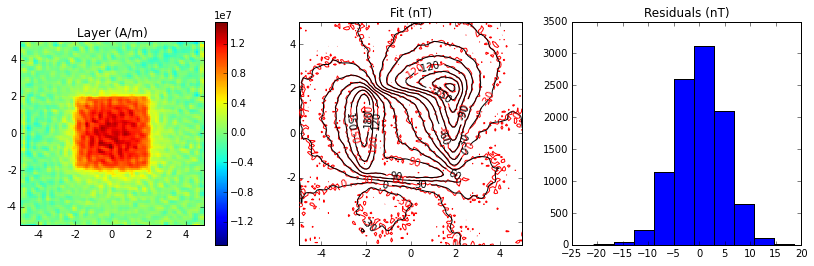

In [8]:

solver = (ajuste + (10**(-16))*regul).fit()

camada.addprop('magnetization', solver.estimate_)

residuos = solver.residuals()

mpl.close('all')
mpl.figure(figsize=(14, 4))
mpl.subplot(1, 3, 1)
mpl.axis('scaled')
mpl.title('Layer (A/m)')
mpl.pcolor(camada.y, camada.x, camada.props['magnetization'], camada.shape)
mpl.colorbar()
mpl.m2km()
mpl.subplot(1, 3, 2)
mpl.axis('scaled')
mpl.title('Fit (nT)')
levels = mpl.contour(y, x, tf, shape, 15, color='r')
mpl.contour(y, x, solver.predicted(), shape, levels, color='k')
mpl.m2km()
mpl.subplot(1, 3, 3)
mpl.title('Residuals (nT)')
mpl.hist(residuos, bins=10)
mpl.show()

In [9]:
''' Cálculo da Amplitude do Sinal Analítico (ASA) '''

asa3D = ASA3D(Dxtf, Dytf, Dztf)
asa3D_Fourier = fourier.ansig(x, y, tf, shape)
asa3D_Fourier_CE = fourier.ansig(x, y, solver.predicted(), shape)

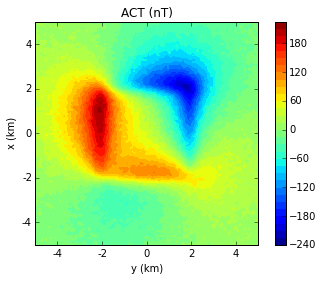

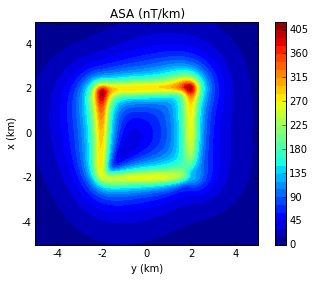

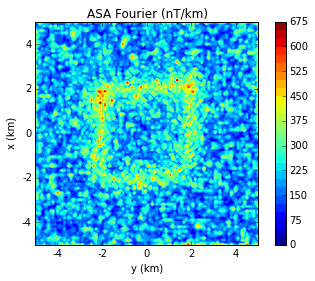

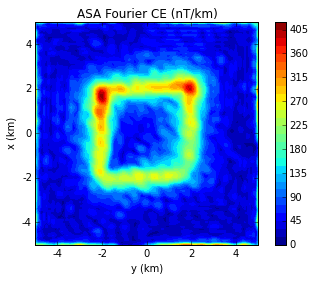

In [10]:
''' Visualização dos resultados '''
mpl.close('all')
mpl.figure()
#mpl.subplot(2, 1, 1)
mpl.title("ACT (nT)")
mpl.axis('scaled')
mpl.contourf(y, x, tf, shape, 30)
mpl.colorbar()
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()
mpl.show()

mpl.close('all')
mpl.figure()
#mpl.subplot(2, 1, 2)
mpl.title("ASA (nT/km)")
mpl.axis('scaled')
mpl.contourf(y, x, 1000.0*asa3D, shape, 30)
mpl.colorbar()
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()
mpl.show()

mpl.close('all')
mpl.figure()
mpl.title("ASA Fourier (nT/km)")
mpl.axis('scaled')
mpl.contourf(y, x, 1000.0*asa3D_Fourier, shape, 30)
mpl.colorbar()
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()
mpl.show()

mpl.close('all')
mpl.figure()
mpl.title("ASA Fourier CE (nT/km)")
mpl.axis('scaled')
mpl.contourf(y, x, 1000.0*asa3D_Fourier_CE, shape, 30)
mpl.colorbar()
mpl.xlabel('y (km)')
mpl.ylabel('x (km)')
mpl.m2km()
mpl.show()